# Synthetic data generation

#### Leonardo Pacciani-Mori
This notebook is part of the [real estate analysis project](https://leonardo.pm/projects/1-italian-real-estate/) from [my portfolio](https://leonardo.pm/projects/).

This notebook and the code within it are released under the GNU General Public License v3. See [here](https://www.gnu.org/licenses/gpl-3.0.en.html) for more details.

First of all, let's start by importing all the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from ctgan import CTGAN
from sdv.evaluation.single_table import evaluate_quality
from sdv.metadata import SingleTableMetadata
import matplotlib.pyplot as plt
import sys
import re
from io import StringIO
import geopandas as gpd
from shapely.geometry import Point
import random
import warnings
warnings.filterwarnings('ignore')

Next, we define some global variables:

In [2]:
# This variable contains the information necessary to connect to the PostgreSQL data warehouse
db_params = {
        'host': 'localhost',
        'port': '5432',
        'user': 'lpm',
        'password': 'LeonardoPostgreSQL',
        'dbname': 'immobiliare_warehouse'
    }

# This variable sets the limit on the number of records to get from the PostgreSQL
# data warehouse. If None, the script gets ALL the records
limit = None

Let's now define some helper functions:

In [3]:
def one_hot_encode_in_place(df, column_name, prefix=None, drop_first=False, dummy_na=False):
    '''
    This function one-hot encodes a column and places the resulting columns at the original column's position.
    '''
    
    # Gets the position of the column
    column_position = df.columns.get_loc(column_name)
    
    # Splits the DataFrame
    df_before = df.iloc[:, :column_position]
    df_after = df.iloc[:, column_position+1:]
    
    # One-hot encodes the column
    prefix = prefix or column_name
    dummies = pd.get_dummies(df[column_name], prefix=prefix, drop_first=drop_first, dummy_na=dummy_na)
    
    # Concatenatse the parts back together
    result = pd.concat([df_before, dummies, df_after], axis=1)
    
    return result

In [4]:
def random_round(x):
    '''
    This function rounds a number randomly if it is exactly in a middle point.
    This is needed below when rounding the synthetic data
    '''
    floor = np.floor(x)

    # If the number is at an exact midpoint
    if x == floor + 0.5:  
        # 50% chance of rounding up or down
        return floor + np.random.randint(0, 2)  
    else:
        return round(x)

In [5]:
def validate_and_correct_coordinates(row, provinces_gdf, province_column='province'):
    '''
    This function checks if the coordinates of a listing fall within the specified province.
    If not, generates new random coordinates within that same province.
    '''
    # Gets province name 
    province_name = row[province_column]

    # Gets province two-letter code
    province_code = prov_to_code[province_name]
    
    # If we need to use a mapping dictionary
    # if province_name in province_name_mapping:
    #     province_name = province_name_mapping[province_name]
    
    # Creates a point from latitude/longitude
    point = Point(row['longitude'], row['latitude'])
    
    # Finds the province geometry
    province_geometry = provinces_gdf[provinces_gdf['prov_sigla'] == province_code]
    
    # If province is not found in geodataframe, returns original row
    if len(province_geometry) == 0:
        print(f"Warning: Province '{province_name}' not found in shapefile.")
        return row
    
    # Checks if point is within the province
    is_within = province_geometry.geometry.contains(point).any()
    
    # If point is not within province, generates a new point
    if not is_within:
        # Gets the province polygon
        polygon = province_geometry.geometry.iloc[0]
        
        # Generates a random point within the polygon's bounds
        minx, miny, maxx, maxy = polygon.bounds
        
        # Keeps trying until we find a point within the polygon
        while True:
            random_x = random.uniform(minx, maxx)
            random_y = random.uniform(miny, maxy)
            random_point = Point(random_x, random_y)
            
            if polygon.contains(random_point):
                # Updates coordinates
                row['longitude'] = random_x
                row['latitude'] = random_y
                break
                
    return row

We also define some classes needed below:

In [6]:
class TeeStderr:
    '''
    This class is defined to capture stderr while still displaying it. This is needed
    in the class definition below in order to record the training losses of the CTGAN
    and plot it (which is normally not possible within the ctgan library)
    '''
    def __init__(self):
        self.buffer = StringIO()
        self.stderr = sys.stderr
        
    def write(self, data):
        self.buffer.write(data)
        self.stderr.write(data)
        
    def flush(self):
        self.stderr.flush()
        
    def getvalue(self):
        return self.buffer.getvalue()

In [7]:
class CustomCTGAN(CTGAN):    
    '''
    This class is defined so that we can plot the losses of the CTGAN's generator
    and discriminator after training (which is not possible normally with the ctgan library).
    '''
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_history = {'generator': [], 'discriminator': []}
        
    def fit(self, train_data, discrete_columns=(), epochs=None):
        # Creates a custom stderr handler
        tee_stderr = TeeStderr()
        original_stderr = sys.stderr
        
        try:
            # Redirects stderr to our custom handler
            sys.stderr = tee_stderr
            
            # Calls the parent class fit method
            super().fit(train_data, discrete_columns, epochs)
            
            # Gets the captured output
            output = tee_stderr.getvalue()
            
            # Parses the output to extract loss values
            loss_pattern = r'Gen\. \(([-]?\d+\.\d+)\) \| Discrim\. \(([-]?\d+\.\d+)\)'
            
            for match in re.finditer(loss_pattern, output):
                g_loss, d_loss = match.groups()
                self.loss_history['generator'].append(float(g_loss))
                self.loss_history['discriminator'].append(float(d_loss))
                
        finally:
            # Makes sure to restore stderr even if an exception occurs
            sys.stderr = original_stderr
            
        return self
    
    def plot_losses(self, figsize=(12, 6), data_type=None):
        plt.style.use("bmh")
        plt.figure(figsize=figsize)
        
        # Gets the actual number of epochs that were actually run
        # (we get two reported losses per epoch)
        epochs_run = len(self.loss_history['generator']) // 2 
        
        # Creates an x-axis that properly represents epochs
        x_ticks = np.linspace(0, epochs_run, len(self.loss_history['generator']))
        
        plt.plot(x_ticks, self.loss_history['generator'], label='Generator Loss')
        plt.plot(x_ticks, self.loss_history['discriminator'], label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        # Uses the provided data_type in the title if available
        if data_type:
            plt.title(f'CTGAN Training Losses for {data_type} data')
        else:
            plt.title('CTGAN Training Losses')
            
        plt.legend()
        plt.show()

## Data extraction and preprocessing

Let's extract all the records from the PostgreSQL warehouse:

In [8]:
print(f"Extracting data from PostgreSQL{' (limited to ' + str(limit) + ' records)' if limit else ''}...")

# Connects to PostgreSQL
conn_string = (
    f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@"
    f"{db_params['host']}:{db_params['port']}/{db_params['dbname']}"
)
engine = create_engine(conn_string)

# SQL query to extract data of interest
# For listing scraped on multiple dates, only gets earliest occurrence
query = """
        WITH earliest_date AS (
        SELECT 
        fl.listing_id,
        MIN(dd.date_value) AS earliest_date
        FROM 
        fact_listing fl
        JOIN 
        dim_date dd ON fl.date_id = dd.date_id
        GROUP BY 
        fl.listing_id
        )
        SELECT 
        fl.listing_id,
        dlt.listing_type,
        fl.price,
        fl.surface,
        dst.seller_type,
        dac.condominium_monthly_expenses,
        dac.heating_yearly_expenses,
        dtp.type_of_property,
        dc.condition,
        dcat.category_name,
        dri.total_room_number,
        dri.bathrooms_number,
        dri.kitchen_status,
        dri.garage,
        dri.floor,
        dbi.has_elevator,
        dbi.building_usage,
        dbi.building_year,
        dei.is_zero_energy_building AS is_zero_energy,
        dei.heating_type,
        dei.energy_class,
        dei.air_conditioning,
        dli2.latitude,
        dli2.longitude,
        dli2.region,
        dli2.province
        FROM 
        fact_listing fl
        JOIN 
        earliest_date ed ON fl.listing_id = ed.listing_id
        JOIN 
        dim_date dd ON fl.date_id = dd.date_id AND dd.date_value = ed.earliest_date
        JOIN 
        dim_listing_type dlt ON fl.listing_type_id = dlt.listing_type_id
        LEFT JOIN 
        dim_listing_info dli ON fl.listing_info_id = dli.listing_info_id
        LEFT JOIN 
        dim_seller_type dst ON dli.seller_type_id = dst.seller_type_id
        LEFT JOIN 
        dim_additional_costs dac ON fl.additional_costs_id = dac.additional_costs_id
        LEFT JOIN 
        dim_type_of_property dtp ON fl.type_of_property_id = dtp.type_of_property_id
        LEFT JOIN 
        dim_condition dc ON fl.condition_id = dc.condition_id
        LEFT JOIN 
        dim_category dcat ON fl.category_id = dcat.category_id
        LEFT JOIN 
        dim_rooms_info dri ON fl.rooms_info_id = dri.rooms_info_id
        LEFT JOIN 
        dim_building_info dbi ON fl.building_info_id = dbi.building_info_id
        LEFT JOIN 
        dim_energy_info dei ON fl.energy_info_id = dei.energy_info_id
        LEFT JOIN 
        dim_location_info dli2 ON fl.location_info_id = dli2.location_info_id
        """

# Adds limit clause if specified
if limit is not None:
    query += f" LIMIT {limit}"

# Executes the query and loads results into a pandas DataFrame
with engine.connect() as connection:
    df = pd.read_sql(query, connection.connection)

# Gets the features from the bridge table
features_query = """
        WITH earliest_date AS (
        SELECT
        fl.listing_id,
        MIN(dd.date_value) AS earliest_date
        FROM 
        fact_listing fl
        JOIN 
        dim_date dd ON fl.date_id = dd.date_id
        GROUP BY 
        fl.listing_id
        )
        SELECT 
        lfb.listing_id,
        df.feature_name
        FROM 
        listing_features_bridge lfb
        JOIN 
        earliest_date ed ON lfb.listing_id = ed.listing_id
        JOIN 
        fact_listing fl ON lfb.listing_id = fl.listing_id
        JOIN 
        dim_date dd ON fl.date_id = dd.date_id AND dd.date_value = ed.earliest_date
        JOIN 
        dim_features df ON lfb.feature_id = df.feature_id
        """

# If a limit is specified, adjusts the features query accordingly
if limit is not None:
    features_query = f"""
    WITH limited_listings AS (
    SELECT listing_id FROM ({query}) as limited
    ),
    earliest_listings AS (
        SELECT 
            fl.listing_id,
            fl.date_id,
            MIN(dd.date_value) as earliest_date
        FROM 
            fact_listing fl
        JOIN 
            dim_date dd ON fl.date_id = dd.date_id
        WHERE
            fl.listing_id IN (SELECT listing_id FROM limited_listings)
        GROUP BY 
            fl.listing_id, fl.date_id 
    )
    SELECT 
        lfb.listing_id,
        df.feature_name
    FROM 
        listing_features_bridge lfb
    JOIN 
        earliest_listings el ON lfb.listing_id = el.listing_id AND lfb.date_id = el.date_id
    JOIN 
        dim_features df ON lfb.feature_id = df.feature_id
        """

# Executes the features query
with engine.connect() as connection:
    features_df = pd.read_sql(features_query, connection.connection)

# Processes the features into one-hot encoded columns
if not features_df.empty:
    features_pivot = pd.crosstab(
        index=features_df['listing_id'],
        columns=features_df['feature_name'],
        values=1,
        aggfunc='max'
    ).fillna(0).astype(int)
    
    # Resets index to merge with main dataframe
    features_pivot = features_pivot.reset_index()
    
    # Merges with main dataframe
    df = pd.merge(df, features_pivot, on='listing_id', how='left')
    
    # Fills NaN values in feature columns with 0
    feature_cols = features_pivot.columns.tolist()
    feature_cols.remove('listing_id')
    df[feature_cols] = df[feature_cols].fillna(0)
    
raw_data = df

print(f"Extracted {len(raw_data)} records")

Extracting data from PostgreSQL...
Extracted 1024934 records


Let's now do some data cleaning and preparation (e.g., replace `NaN` values):

In [9]:
# Removes spurious column
pop_column = raw_data.pop("db fullname external fixtures. id 7m")

# Replaces NaNs with medians in numerical columns
raw_data['surface'] = raw_data['surface'].fillna(raw_data['surface'].median())
raw_data['condominium_monthly_expenses'] = raw_data['condominium_monthly_expenses'].fillna(raw_data['condominium_monthly_expenses'].median())
raw_data['heating_yearly_expenses'] = raw_data['heating_yearly_expenses'].fillna(raw_data['heating_yearly_expenses'].median())
raw_data['total_room_number'] = raw_data['total_room_number'].fillna(raw_data['total_room_number'].median())
raw_data['bathrooms_number'] = raw_data['bathrooms_number'].fillna(raw_data['bathrooms_number'].median())
raw_data['floor'] = raw_data['floor'].fillna(raw_data['floor'].median())
raw_data['bathrooms_number'] = raw_data['bathrooms_number'].fillna(raw_data['bathrooms_number'].median())
raw_data.loc[raw_data['building_year'] < 0, 'building_year'] = raw_data['building_year'].median()
raw_data['building_year'] = raw_data['building_year'].fillna(raw_data['building_year'].median())
raw_data['latitude'] = raw_data['latitude'].fillna(raw_data['latitude'].median())
raw_data['longitude'] = raw_data['longitude'].fillna(raw_data['longitude'].median())

# Replaces NaNs with "unknown" in categorical columns
raw_data['condition'] = raw_data['condition'].fillna("unknown")
raw_data['kitchen_status'] = raw_data['kitchen_status'].fillna("unknown")
raw_data['building_usage'] = raw_data['building_usage'].fillna("unknown")
raw_data['heating_type'] = raw_data['heating_type'].fillna("unknown")
raw_data['air_conditioning'] = raw_data['air_conditioning'].fillna("unknown")

# Replaces False and None with 0 and True with 1 in boolean columns
raw_data['has_elevator'] = raw_data['has_elevator'].map(lambda x: 1 if x is True else 0)
raw_data['is_zero_energy'] = raw_data['is_zero_energy'].map(lambda x: 1 if x is True else 0)

# Special columns: garage, energy_class and type_of_property
# garage: every entry with text is converted to 1 (True), everyting else with 0
raw_data['garage'] = raw_data['garage'].apply(lambda x: 1 if isinstance(x, str) else 0)

# energy_class: classes are converted to numbers, where the most energy efficient is
# A4 (→1) and the least energy efficient is G (→10)
energy_class_mapping = {
    'a4': 1,
    'a3': 2,
    'a2': 3,
    'a1': 4,
    'a+': 4,  # a+ and a1 are the same class
    'b': 5,
    'c': 6,
    'd': 7,
    'e': 8,
    'f': 9,
    'g': 10,
    None: None  # Keep None as None (will become NaN in numeric column)
}
# Applies the mapping to the column
raw_data['energy_class'] = raw_data['energy_class'].map(energy_class_mapping)
raw_data['energy_class'] = raw_data['energy_class'].fillna(raw_data['energy_class'].median())

# type_of_property: only keeps the value before the first |, then apply some substitutions
raw_data['type_of_property'] = raw_data['type_of_property'].str.split('|', n=1).str[0].str.strip()
raw_data['type_of_property'] = raw_data['type_of_property'].replace({'attic - attic': 'attic',
                                                                     'mansarda': 'attic',
                                                                     '': 'unknown',
                                                                     '♪': 'unknown',
                                                                     'holiday in villa': 'vacation villa',
                                                                     'vacation in villa': 'vacation villa',
                                                                     'holiday in apartment': 'vacation apartment',
                                                                     'holiday in the house for holidays': 'vacation house',
                                                                     'holiday home for holidays': 'vacation house', 
                                                                     'holiday home': 'vacation house',
                                                                     'vacation in the house for holidays': 'vacation house',
                                                                     'holidays in bed & breakfast': 'bed & breakfast',
                                                                     'holidays in farmhouse': 'vacation farmhouse',
                                                                     'holidays in residence': 'vacation residence',
                                                                     'warehouse or warehouse': 'warehouse',
                                                                     'land - agricultural land': 'agricultural land',
                                                                     'estate or estate': 'estate',
                                                                     'rustic - building land residential': 'rustic',
                                                                     'historical abode': 'historical residence',
                                                                     'warehouse or storage': 'storage'
                                                                    })

# Removes the rows that have null values in price
raw_data.dropna(subset=['price','region','province'], inplace=True)


# Defines the categorical columns (this variable is needed later for model training)
categorical_columns =  [col for col in raw_data.columns if col not in ["listing_id","listing_type","price","surface",
                                                                       "condominium_monthly_expenses","heating_yearly_expenses",
                                                                       "building_year", "latitude", "longitude"]]

Let's now divide the data into three dataframes, one for each listing type:

In [10]:
rent_data = raw_data[raw_data['listing_type'] == 'rent'].drop('listing_type', axis=1)
sale_data = raw_data[raw_data['listing_type'] == 'sale'].drop('listing_type', axis=1)
auction_data = raw_data[raw_data['listing_type'] == 'auction'].drop('listing_type', axis=1)


# In order to avoid generating negative values for the numerical columns that only
# admit positive values (e.g., "price" and "surface"), we log-transform the data
# and then reverse transform it after the synthetic data generation

# price
rent_data['price'] = np.log1p(rent_data['price'])  
sale_data['price'] = np.log1p(sale_data['price'])
auction_data['price'] = np.log1p(auction_data['price'])

# surface
rent_data['surface'] = np.log1p(rent_data['surface'])  
sale_data['surface'] = np.log1p(sale_data['surface'])
auction_data['surface'] = np.log1p(auction_data['surface'])

# condominium_monthly_expenses
rent_data['condominium_monthly_expenses'] = np.log1p(rent_data['condominium_monthly_expenses'])  
sale_data['condominium_monthly_expenses'] = np.log1p(sale_data['condominium_monthly_expenses'])
auction_data['condominium_monthly_expenses'] = np.log1p(auction_data['condominium_monthly_expenses'])

# heating_yearly_expenses
rent_data['heating_yearly_expenses'] = np.log1p(rent_data['heating_yearly_expenses'])  
sale_data['heating_yearly_expenses'] = np.log1p(sale_data['heating_yearly_expenses'])
auction_data['heating_yearly_expenses'] = np.log1p(auction_data['heating_yearly_expenses'])

## Generative model (CTGAN) training

We now proceed to use the three dataframes above to train three different generative models (CTGANs), one for each listing type.

Please note that each model has its own set of parameters (in particular, the learning rates for the generator and the discriminator).

Training CTGAN model on rent data: 75672 records


Gen. (-4.52) | Discrim. (-0.10): 100%|##########| 200/200 [07:42<00:00,  2.31s/it]


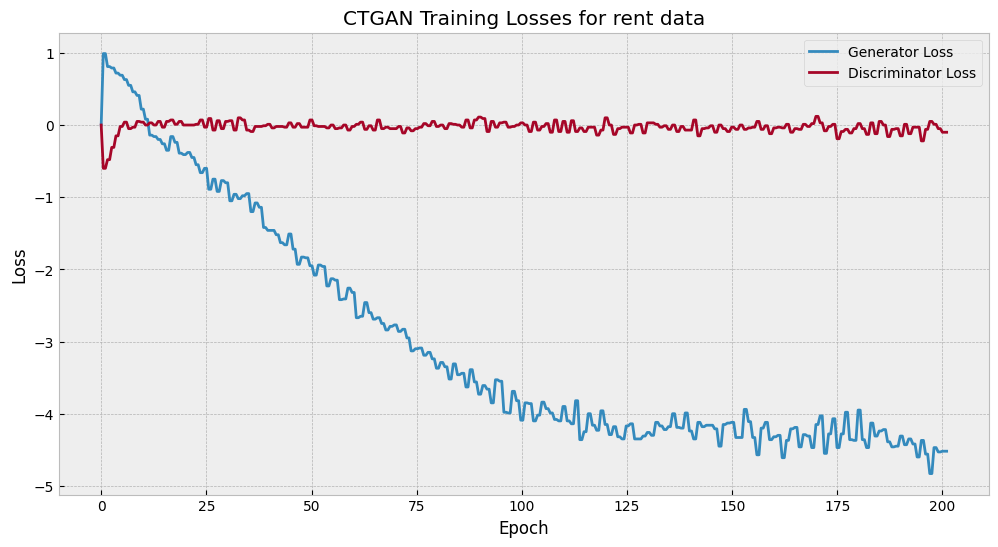

In [11]:
print(f"Training CTGAN model on rent data: {len(rent_data)} records")
    
# Initializes CTGAN model
ctgan_model_rent = CustomCTGAN(
                               epochs=200,
                               batch_size=5000,
                               generator_lr = 2e-4,
                               discriminator_lr = 5e-5,
                               verbose=True,
                               cuda=True
                              )

# Trains the model
ctgan_model_rent.fit(rent_data,categorical_columns)

# Saves the model
ctgan_model_rent.save(f'ctgan_model_rent.pkl')

# Plots the losses during training
ctgan_model_rent.plot_losses(data_type="rent")

Training CTGAN model on auction data: 114551 records


Gen. (-2.85) | Discrim. (-0.15): 100%|##########| 200/200 [10:31<00:00,  3.16s/it]


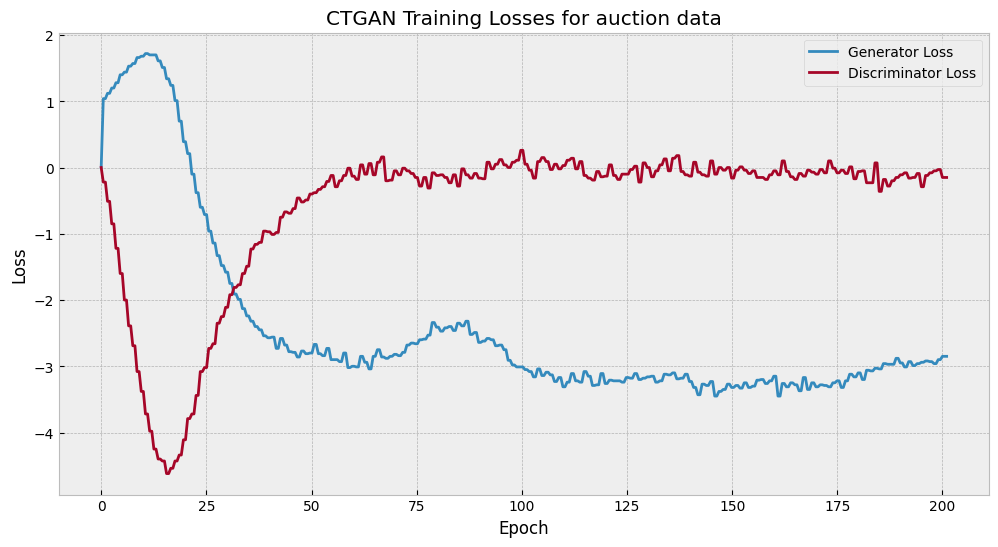

In [12]:
print(f"Training CTGAN model on auction data: {len(auction_data)} records")
    
# Initializes CTGAN model
ctgan_model_auction = CustomCTGAN(
                               epochs=200,
                               batch_size=5000,
                               generator_lr = 1e-5,
                               discriminator_lr = 1e-5,
                               verbose=True,
                               cuda=True
                              )

# Trains the model
ctgan_model_auction.fit(auction_data,categorical_columns)

# Saves the model
ctgan_model_auction.save(f'ctgan_model_auction.pkl')

# Plots the losses during training
ctgan_model_auction.plot_losses(data_type="auction")

Training CTGAN model on sale data: 834651 records


Gen. (-0.28) | Discrim. (-0.21): 100%|##########| 400/400 [2:55:31<00:00, 26.33s/it]  


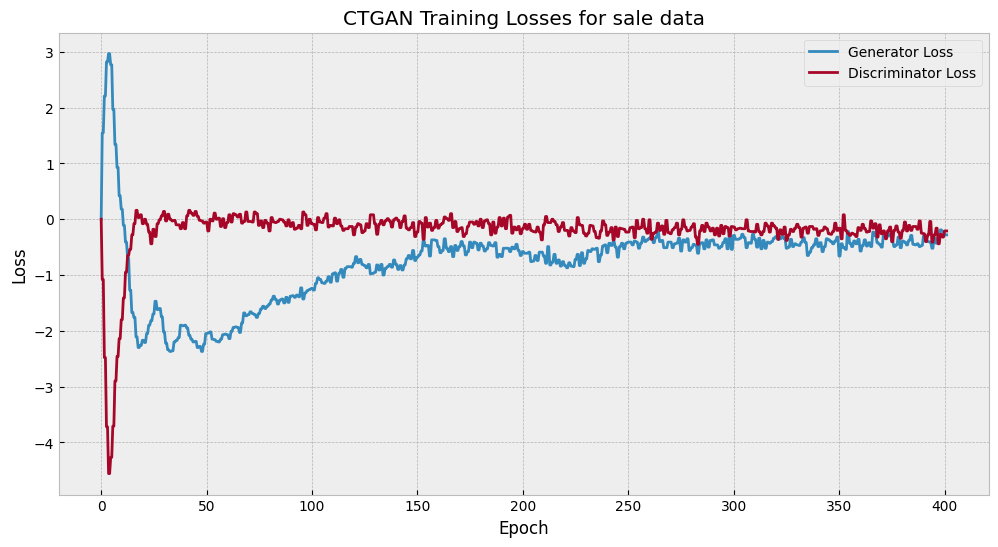

In [13]:
print(f"Training CTGAN model on sale data: {len(sale_data)} records")

# Initializes CTGAN model
ctgan_model_sale = CustomCTGAN(
                               epochs=400,
                               batch_size=5000,
                               generator_lr = 5e-6,
                               discriminator_lr = 5e-6,
                               verbose=True,
                               cuda=True
                              )

# Trains the model
ctgan_model_sale.fit(sale_data,categorical_columns)

# Saves the model
ctgan_model_sale.save(f'ctgan_model_sale.pkl')

# Plots the losses during training
ctgan_model_sale.plot_losses(data_type="sale")

## Synthetic data generation and evaluation

Now we proceed to generate synthetic data using the three models trained above.

We generate a number of records similar to the one in the original data.

In [14]:
num_samples_rent = 80000
num_samples_auction = 120000
num_samples_sale = 850000

In [15]:
print(f"Generating {num_samples_rent} synthetic records for rent data...")
synthetic_rent_data = ctgan_model_rent.sample(num_samples_rent)

# Reverse-transforms columns that do not admit negative values for rent data
synthetic_rent_data['price'] = np.expm1(synthetic_rent_data['price'])
synthetic_rent_data['surface'] = np.expm1(synthetic_rent_data['surface'])
synthetic_rent_data['condominium_monthly_expenses'] = np.expm1(synthetic_rent_data['condominium_monthly_expenses'])
synthetic_rent_data['heating_yearly_expenses'] = np.expm1(synthetic_rent_data['heating_yearly_expenses'])

Generating 80000 synthetic records for rent data...


In [16]:
print(f"Generating {num_samples_auction} synthetic records for auction data...")
synthetic_auction_data = ctgan_model_auction.sample(num_samples_auction)

# Reverse-transforms columns that do not admit negative values for auction data
synthetic_auction_data['price'] = np.expm1(synthetic_auction_data['price'])
synthetic_auction_data['surface'] = np.expm1(synthetic_auction_data['surface'])
synthetic_auction_data['condominium_monthly_expenses'] = np.expm1(synthetic_auction_data['condominium_monthly_expenses'])
synthetic_auction_data['heating_yearly_expenses'] = np.expm1(synthetic_auction_data['heating_yearly_expenses'])

Generating 120000 synthetic records for auction data...


In [17]:
print(f"Generating {num_samples_sale} synthetic records for sale data...")
synthetic_sale_data = ctgan_model_sale.sample(num_samples_sale)

# Reverse-transforms columns that do not admit negative values for sale data
synthetic_sale_data['price'] = np.expm1(synthetic_sale_data['price'])
synthetic_sale_data['surface'] = np.expm1(synthetic_sale_data['surface'])
synthetic_sale_data['condominium_monthly_expenses'] = np.expm1(synthetic_sale_data['condominium_monthly_expenses'])
synthetic_sale_data['heating_yearly_expenses'] = np.expm1(synthetic_sale_data['heating_yearly_expenses'])

Generating 850000 synthetic records for sale data...


We then evaluate the synthetic data's quality using the SDV quality score:

In [18]:
print("Evaluating quality of synthetic rent data...")

# Creates metadata for the SDV evaluator
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(rent_data)

# Calculates the SDV quality score (0% to 100%, higher is better)
quality_score_rent = evaluate_quality(
                                      synthetic_rent_data, 
                                      rent_data,
                                      metadata
                                     )

Evaluating quality of synthetic rent data...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████████| 72/72 [00:00<00:00, 75.54it/s]|
Column Shapes Score: 88.36%

(2/2) Evaluating Column Pair Trends: |████| 2556/2556 [00:24<00:00, 102.67it/s]|
Column Pair Trends Score: 78.5%

Overall Score (Average): 83.43%



In [19]:
print("Evaluating quality of synthetic auction data...")

# Creates metadata for the SDV evaluator
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(auction_data)

# Calculates the SDV quality score (0% to 100%, higher is better)
quality_score_auction = evaluate_quality(
                                          synthetic_auction_data, 
                                          auction_data,
                                          metadata
                                         )

Evaluating quality of synthetic auction data...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████████| 72/72 [00:01<00:00, 51.97it/s]|
Column Shapes Score: 91.55%

(2/2) Evaluating Column Pair Trends: |█████| 2556/2556 [00:29<00:00, 87.13it/s]|
Column Pair Trends Score: 82.39%

Overall Score (Average): 86.97%



In [20]:
print("Evaluating quality of synthetic sale data...")

# Creates metadata for the SDV evaluator
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(sale_data)

# Calculates the SDV quality score (0% to 100%, higher is better)
quality_score_sale = evaluate_quality(
                                      synthetic_sale_data, 
                                      sale_data,
                                      metadata
                                      )

Evaluating quality of synthetic sale data...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████████| 72/72 [00:09<00:00,  7.22it/s]|
Column Shapes Score: 92.34%

(2/2) Evaluating Column Pair Trends: |█████| 2556/2556 [01:26<00:00, 29.42it/s]|
Column Pair Trends Score: 85.4%

Overall Score (Average): 88.87%



As we can see all the quality scores are very good (as explained also [here](https://docs.sdv.dev/sdv/multi-table-data/evaluation/data-quality#interpreting-the-score), the score goes from 0% to 100% with higher scores meaning higher similarity between the synthetic and original data), and the losses' behaviors are also what we would expect from a well trained CTGAN (see [this article](https://github.com/sdv-dev/SDV/discussions/980)).

We can therefore conclude that our three generative models are trained correctly and are able to create synthetic data that has the same properties as the original data.

## Synthetic data processing

We now do some post-processing to the data to get a unique dataset.

First, we put the three types of synthetic data back together in one unique dataframe:

In [21]:
# Adds listing_type column back to each synthetic dataframe
synthetic_rent_data['listing_type'] = 'rent'
synthetic_auction_data['listing_type'] = 'auction'
synthetic_sale_data['listing_type'] = 'sale'

# Positions the listing_type column after listing_id and before price
for df in [synthetic_rent_data, synthetic_auction_data, synthetic_sale_data]:
    # Removes the column to reposition it
    listing_type = df.pop('listing_type') 
    
    # Determines position to insert the listing_type column
    if 'listing_id' in df.columns:
        # If listing_id exists, inserts after it
        pos = list(df.columns).index('listing_id') + 1
    elif 'price' in df.columns:
        # If price exists (and listing_id doesn't), inserts before it
        pos = list(df.columns).index('price')
    else:
        # If neither exists, insert at the beginning
        pos = 0
    
    df.insert(pos, 'listing_type', listing_type)

# Concatenates the dataframes
combined_synthetic_data = pd.concat([synthetic_rent_data, synthetic_auction_data, synthetic_sale_data], 
                                   ignore_index=True)

# Shuffles the rows
synthetic_data_all = combined_synthetic_data.sample(frac=1, random_state=42).reset_index(drop=True)

Then, we round the numerical columns as follows:
- `price`: rounded to the nearest decade
- `surface`: rounded to the nearest integer
- `condominium_monthly_expenses`: rounded to the second decimal figure
- `heating_yearly_expenses`: rounded to the second decimal figure
- `total_room_number`: rounded to the nearest integer, keeping 6 as the maximum value
- `total_bathrooms_number`: rounded to the nearest integer, keeping 4 as the maximum value
- `floor`: rounded to the nearest integer
- `building_year`: rounded to the nearest integer
- `energy_class`: rounded to the nearest integer, keeping the values between 1 and 10

In [22]:
# Rounds price to nearest decade
synthetic_data_all['price'] = synthetic_data_all['price'].apply(lambda x: round(x / 10) * 10)

# Rounds surface to nearest integer
synthetic_data_all['surface'] = synthetic_data_all['surface'].apply(random_round)

# Rounds condominium and heating expenses to 2 decimal places
synthetic_data_all['condominium_monthly_expenses'] = synthetic_data_all['condominium_monthly_expenses'].round(2)
synthetic_data_all['heating_yearly_expenses'] = synthetic_data_all['heating_yearly_expenses'].round(2)

# Rounds and constrains total_room_number between 1 and 6
synthetic_data_all['total_room_number'] = synthetic_data_all['total_room_number'].apply(
                                                                                        lambda x: np.clip(random_round(x), 1, 6)
                                                                                       )

# Rounds and constrains bathrooms_number between 1 and 4
synthetic_data_all['bathrooms_number'] = synthetic_data_all['bathrooms_number'].apply(
                                                                                      lambda x: np.clip(random_round(x), 1, 4)
                                                                                     )

# Rounds floor to nearest integer
synthetic_data_all['floor'] = synthetic_data_all['floor'].apply(random_round)

# Rounds building_year to nearest integer
synthetic_data_all['building_year'] = synthetic_data_all['building_year'].apply(random_round)

# Rounds and constrain energy_class between 1 and 10
synthetic_data_all['energy_class'] = synthetic_data_all['energy_class'].apply(
                                                                              lambda x: np.clip(random_round(x), 1, 10)
                                                                             )

Finally, we need to do check the positions of the listings: in fact, it could be that the generated latitude/longitude in a row do not actually belong to the row's province.

Therefore, for each row we need to check that the latitude/longitude point actually sits within that province, and if not we substitute them with randomly generated latitue/longitude inside the same province:

In [23]:
# First, some processing needed for consistency below: we change all occurrences of "l'aquila"
# in the column "province" with "aquila", and also "monza-e-brianza" to "monza-brianza"
synthetic_data_all['province'] = synthetic_data_all['province'].str.replace("l'aquila", "aquila", regex=False)
synthetic_data_all['province'] = synthetic_data_all['province'].str.replace("monza-e-brianza", "monza-brianza", regex=False)

In [24]:
# Imports data on all of Italy's provinces (e.g., their names and their two-letter codes), stored in a csv file
prov_df = pd.read_csv("./provinces.csv", sep=",", na_filter=False)

# Creates a dictionary to convert a province's name into its two-letter code
prov_to_code = dict(zip(prov_df["Province"], prov_df["Code"]))

In [25]:
# Loads Italian provinces from GeoJSON file
italian_provinces = gpd.read_file("./georef-italy-provincia.geojson")

# Makes sure the CRS is in the correct format (WGS84 is generally the standard for latitude/longitude)
italian_provinces = italian_provinces.to_crs("EPSG:4326")

In [26]:
# Applies the helper function defined at the beginning to check each latitude/longitude,
# and eventually change them with randomly generated points inside that same province
synthetic_data_all = synthetic_data_all.apply(
                                               lambda row: validate_and_correct_coordinates(row, italian_provinces),
                                               axis=1
                                             )

Now that the data is ready, let's take a look at it:

In [27]:
synthetic_data_all

,listing_id,listing_type,price,surface,seller_type,condominium_monthly_expenses,heating_yearly_expenses,type_of_property,condition,category_name,...,wall cabinet,window frames double glass / metal exterior,window frames exterior double glass / wood,window frames exterior glass / metal,window frames exterior glass / wood,window frames exterior in triple glass / metal,window frames exterior in triple glass / pvc,window frames exterior in triple glass / wood,window frames external double glass / pvc,wired
0,117809654,sale,531170,131,agency,100.00,11.99,apartment,good / habitable,palaces - buildings,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,116689450,sale,210820,94,agency,100.05,12.00,apartment,unknown,palaces - buildings,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,116163428,sale,476240,78,agency,100.01,12.00,apartment,to be restored,residential apartment,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,116771862,rent,570,50,agency,98.78,12.01,apartment,great / renovated,residential apartment,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,106601291,sale,173740,96,agency,99.96,12.01,apartment,good / habitable,residential apartment,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049995,116756003,auction,18480,127,agency,100.04,12.00,apartment,good / habitable,residential apartment,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1049996,56240939,sale,170470,122,agency,100.04,11.99,apartment,new / under construction,residential apartment,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1049997,117758650,auction,177990,72,agency,100.11,11.99,villa,good / habitable,residential apartment,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1049998,115552681,sale,143710,85,agency,100.03,12.00,apartment,great / renovated,residential apartment,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


and finally, let's save it to a csv file:

In [29]:
# Saves the synthetic data to a csv file
synthetic_data_all.to_csv('synthetic_data.csv', index=False)

### This concludes the synthetic data generation part of the project